# Visualizing the filters of a CNN
Understanding how our machine learning models actually work can be challenging.   In assignment 12,we used a method from the book to help us visualize CNN performance: we **made** a test image using backpropagation, such that the image **maximally activated** a given filter.

We will use that same method again, using an already trained CNN (you can see the model by inspecting the file cnn_simple_mnist.py in this directory).  This model is developed on the MNIST sample included with Keras, and has two convolutional layers and a pooling layer.

In [1]:
from keras.models import load_model
import pickle

model = load_model('/fs/scratch/PAS1495/physics6820/cnn_simple_mnist.h5')

print("model summary",model.summary())

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

## Load the data
We will want to run on the data for some of the performance tests, particularly the test data.  

In [2]:
import keras
from keras.datasets import mnist

# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 10

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
input_shape = (1, img_rows, img_cols)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples


## Visualizing the filters of a CNN (continued)
To understand what these filters are doing, we will use a method from Chapter 5 of the Deep Learning with Python text.   The idea is to find an image (starting from a randomly initialized image) which causes each of the filters to respond maximally.   In some sense, this is the stucture that the filter is "looking for" in the input images.

Here is the relevant code from Chapter 5:

In [3]:
import numpy as np
from keras import backend as K

def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
#    x *= 0.3
    
    x+= 0.5
    x = np.clip(x,0,1)
    
    #x*= 255
    #x = np.clip(x,0,255).astype('uint8')
    return x

def generate_pattern(model,layer_name,filter_index,size=28):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    grads = K.gradients(loss,model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input],[loss,grads])
    input_img_data = np.random.random((1,size,size,1))*20+128.0

    step = 0.25
    for i in range(50):
        loss_value,grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

Layer conv2d_1


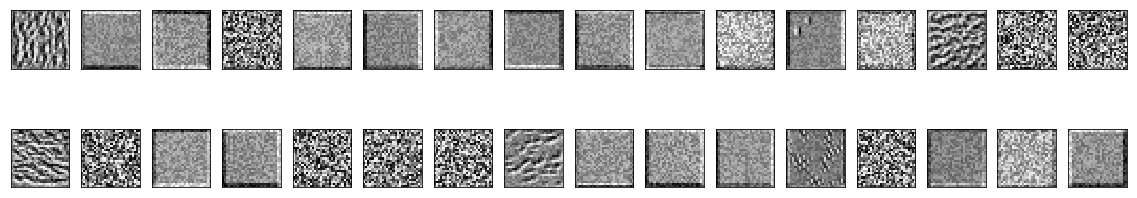

Layer max_pooling2d_1


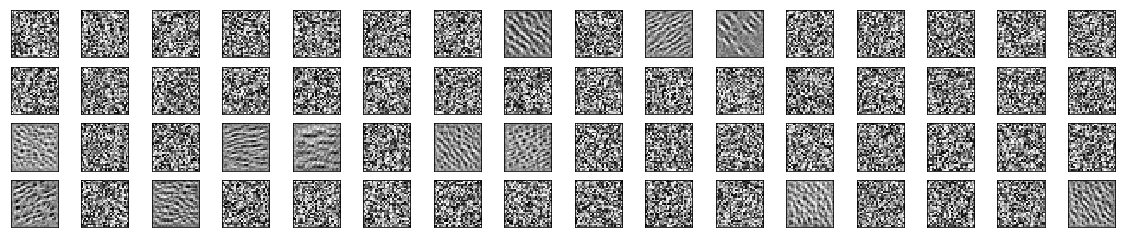

done


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 4))
n=32
nn=16
print("Layer conv2d_1")
for i in range(n):
    # display original
    ax = plt.subplot(2, nn, i + 1)
    thisImg = generate_pattern(model,'conv2d_1',i)
    plt.imshow(thisImg.reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(20, 4))
n=64
print("Layer max_pooling2d_1")
for i in range(n):
    # display original
    ax = plt.subplot(4, nn, i + 1)
    thisImg = generate_pattern(model,'max_pooling2d_1',i)
    plt.imshow(thisImg.reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print("done")

## Visualize the Filter Another Way!
The above images may be a bit... dissatisfying.   There is another way to learn what the filters are doing, and this using the input images themselves.   The basic idea is this:
1.  Loop over all of the images.
2.  For each image, determine the output of each filter at a given layer.
3.  Store the output for that layer and image - we will use a nested dictionary to do this.
4.  Once finished, we can sort the output from highest to lowest, then plot the images which correspond to the largest filter output - we will plot the top 10 or 20 images.

In this way, we can examine the images by filter, and look to see if there are any distinguishing features among the highest output images.

How do we get at the outputs at intermediate layers in a network?   Keras has a nice feature that allows you to define a new Model based on an existing model, where the output of this new model is layer output you desire.   The only thing you need to jnow is the layer name: we get this from the model.summary() function (which we printed above).

In [5]:
#
# Here we can make a new model which has the same inoputs as the VGG model, but has
# an output at an intermediate layer
from keras.models import Model
import time
#
# This info came from inspecting the output of print(model.summary()) above
#
# The output from the first convolutional layer
layer = 1

layer_name = 'conv2d_1'
numxy = 26
filters = 32

if layer==2:
#
# The output from the middle convolutional layer
    layer_name = 'conv2d_2'
    numxy = 24
    filters = 64
#
# The output from the last convolutional layer
elif layer==3:
    layer_name = 'max_pooling2d_1'
    numxy = 12
    filters = 64
#
# This defines a new model which has as its output the output of the above chosen layer
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

print("Predicting outputs for layer ",layer_name)
#
# We use partial instead of autovivify because otherwise we can't pickle the output (not sure why)
#neuronsByImageIndex = autovivify(2,float)
from collections import defaultdict
from functools import partial
neuronsByImageIndex = defaultdict(partial(defaultdict, float))

#
# Put each image in
t0 = time.time()
numFiles = 0
for i in range(len(x_test)):
    img = x_test[i]
    numFiles += 1
    if numFiles%1000 == 0:
        print("Processed ",numFiles,time.time()-t0)
        t0 = time.time()
    #preds = model.predict(img_data)
    decoded_imgs = intermediate_layer_model.predict(img.reshape(1,28,28,1))
    count = 0
    #print(decoded_imgs.shape)
#
# Sum up the activations for this filter in this layer, store them by filter (this is 
# referred to by count) and by the image number (this is referred to by i)
    for i3 in range(filters):
        neuronsByImageIndex[count][i] = decoded_imgs[0,:,:,i3].sum()
        count += 1
        
print("done")


Predicting outputs for layer  conv2d_1
Processed  1000 0.4664649963378906
Processed  2000 0.3682878017425537
Processed  3000 0.37415075302124023
Processed  4000 0.3795309066772461
Processed  5000 0.3737215995788574
Processed  6000 0.3729712963104248
Processed  7000 0.36163902282714844
Processed  8000 0.36121487617492676
Processed  9000 0.38146114349365234
Processed  10000 0.3645634651184082
done


## Using pickle
The python pickle module is very useful for quickly "serializing" a python object to file.  You can then re-load this file using the pickle.load method.  We don't really need to do this for the MNIST case, but will we take advantage of this for a real image dataset: we will use straight python and qsub to calculate the *neuronsByImageIndex* dictionary, and then use pickel to save the results.   We then load that pickle file in jupyter so we can visualize it.

Below we show how to dump the pickle file to disk and then reload it.

In [11]:
import pickle
#
# Save our dictionary
pickle.dump(neuronsByImageIndex,open('neuronsByImageIndex_cnn_mnist_'+layer_name+'.pkl', 'wb') )

#
# Now load the dictionary back!   Usually the saving and re-loading are done in 2 different files!
fname = open('neuronsByImageIndex_cnn_mnist_'+layer_name+'.pkl', 'rb')
neuronsByImageIndex = pickle.load(fname) 
print("neuronsByImageIndex length",len(neuronsByImageIndex))
print(neuronsByImageIndex[1])

neuronsByImageIndex length 32
defaultdict(<class 'float'>, {0: 36.756355, 1: 53.996284, 2: 17.364899, 3: 54.080154, 4: 32.31723, 5: 21.480654, 6: 39.367302, 7: 37.031303, 8: 56.23749, 9: 51.9729, 10: 50.92981, 11: 49.375168, 12: 39.491882, 13: 46.945274, 14: 24.382889, 15: 52.718693, 16: 40.398758, 17: 42.94563, 18: 65.874725, 19: 28.46873, 20: 43.195847, 21: 41.159435, 22: 39.45189, 23: 46.16264, 24: 27.162268, 25: 71.69512, 26: 28.552864, 27: 35.94461, 28: 52.700066, 29: 21.908932, 30: 47.715637, 31: 19.83494, 32: 51.210182, 33: 41.20398, 34: 46.650776, 35: 58.447086, 36: 42.978935, 37: 21.47509, 38: 39.793434, 39: 25.939047, 40: 14.715049, 41: 34.85492, 42: 34.899593, 43: 36.248596, 44: 35.45528, 45: 40.623753, 46: 30.41889, 47: 36.7544, 48: 49.83525, 49: 37.767155, 50: 36.600628, 51: 69.81971, 52: 52.939117, 53: 41.101887, 54: 58.670895, 55: 42.257874, 56: 41.43434, 57: 18.302979, 58: 46.743507, 59: 31.108002, 60: 44.457718, 61: 58.7175, 62: 27.674618, 63: 44.83641, 64: 59.91677, 6

## Displaying the output
Now we can loop over the "neurons" (filters actually) and sort them - then plot the top 10.  Can you see any distinguising patterns among the resulting numbers?

numneurons  32


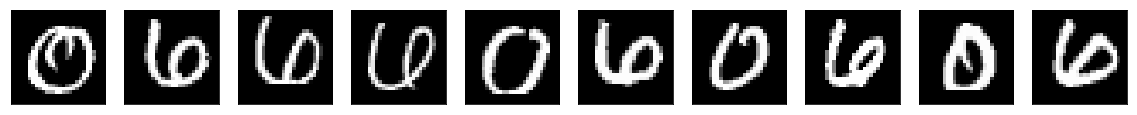

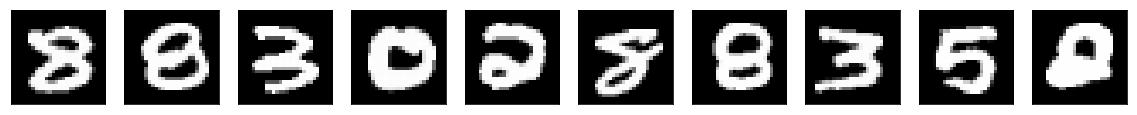

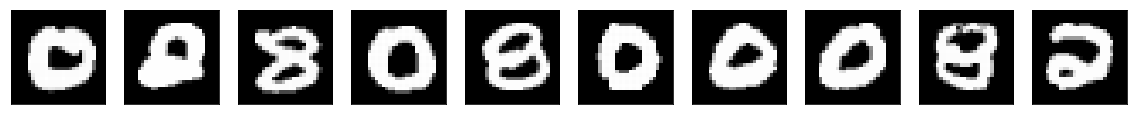

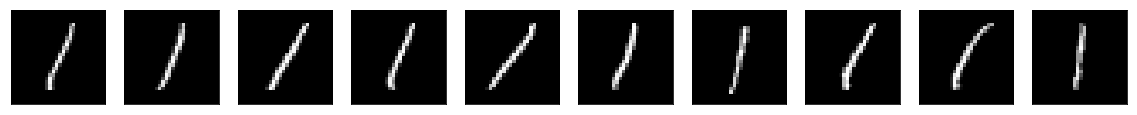

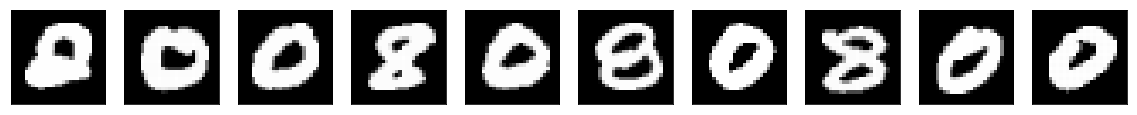

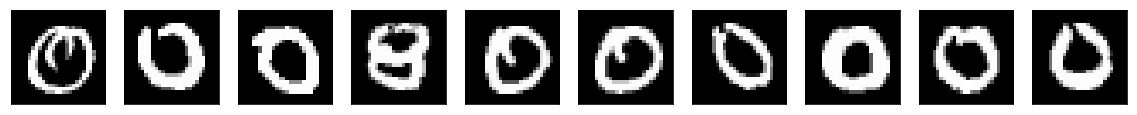

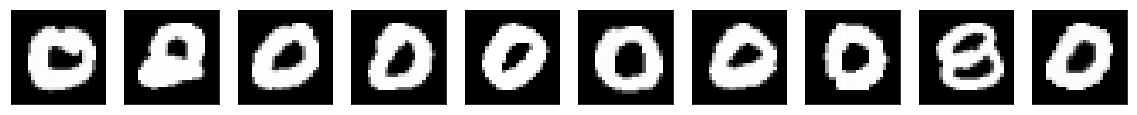

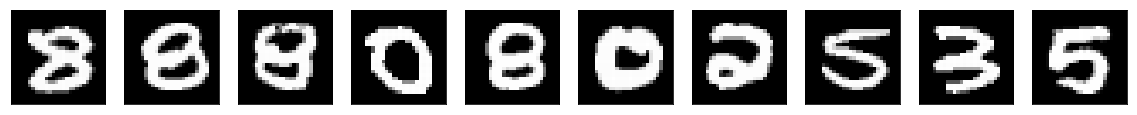

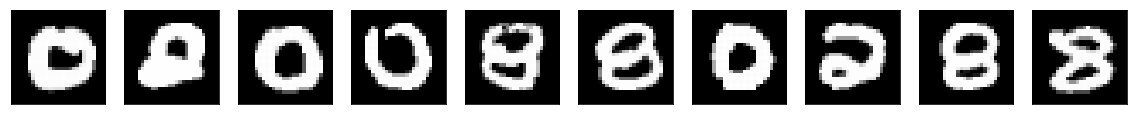

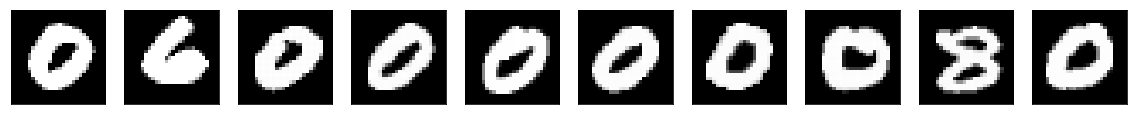

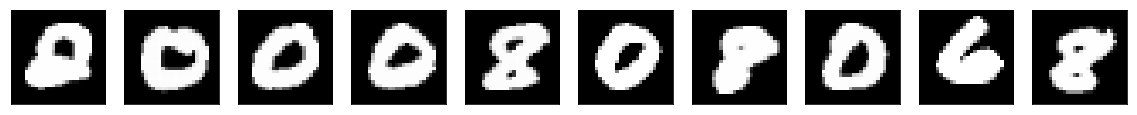

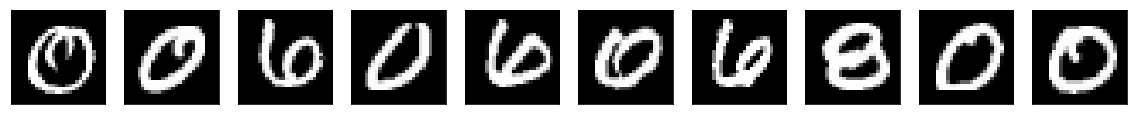

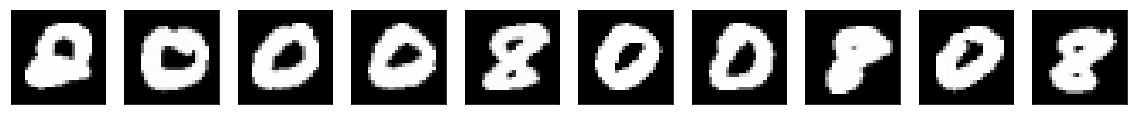

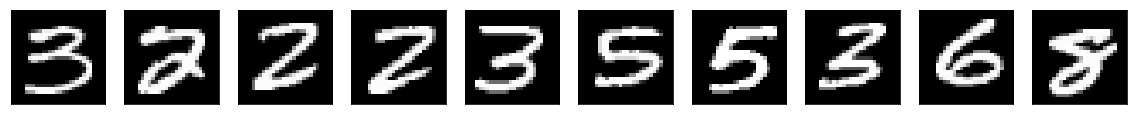

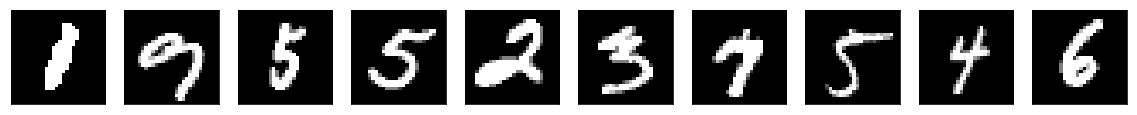

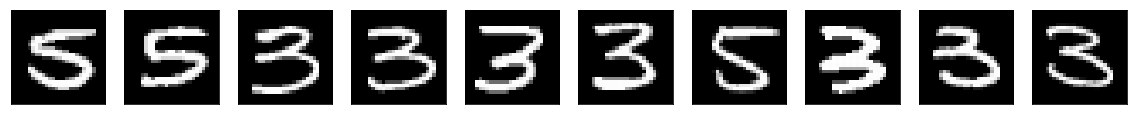

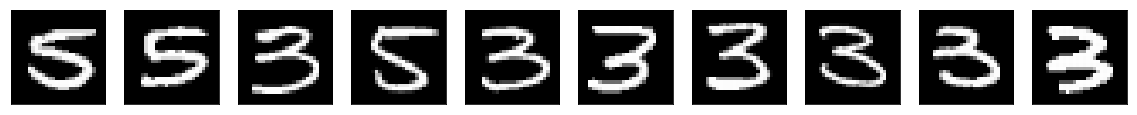

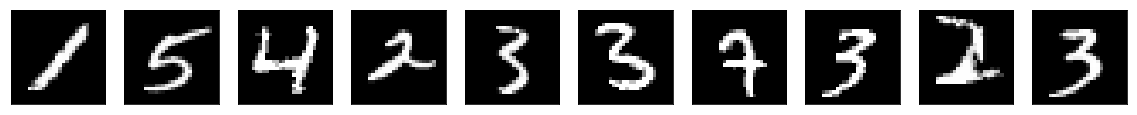

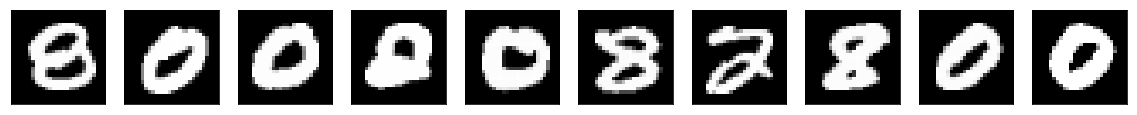

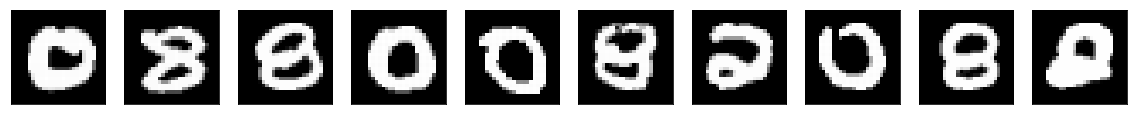

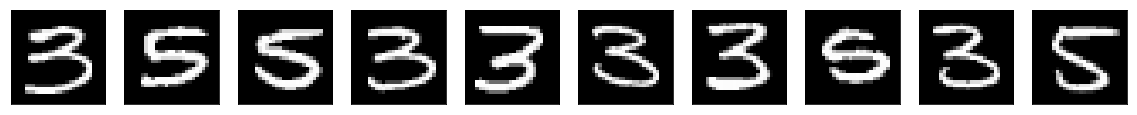

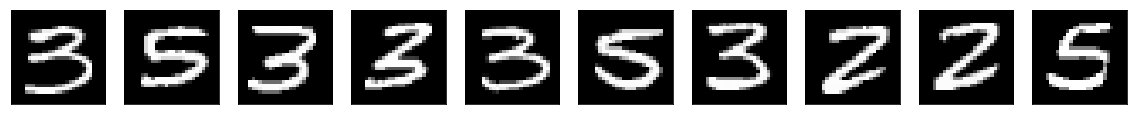

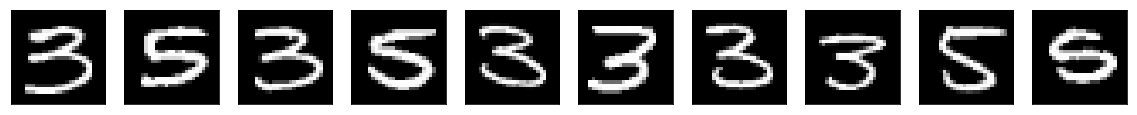

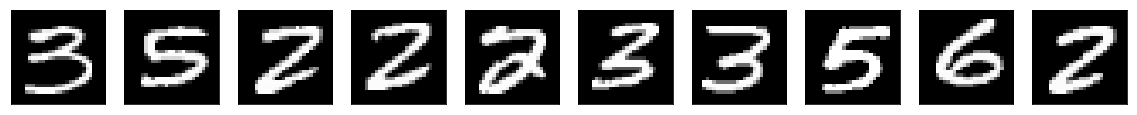

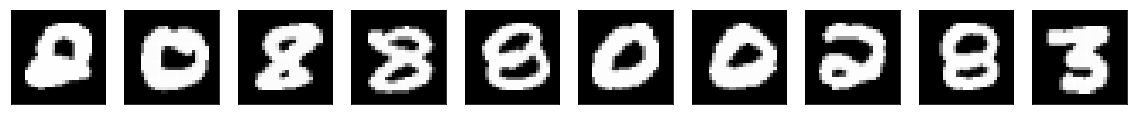

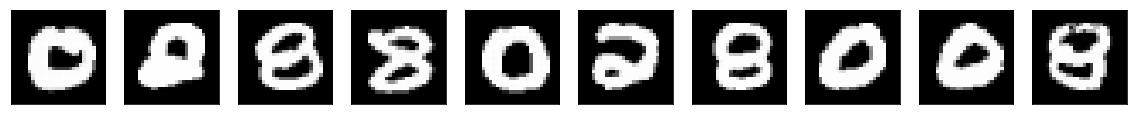

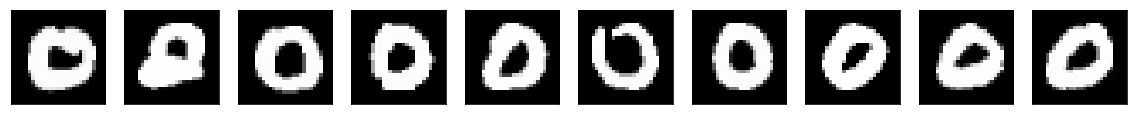

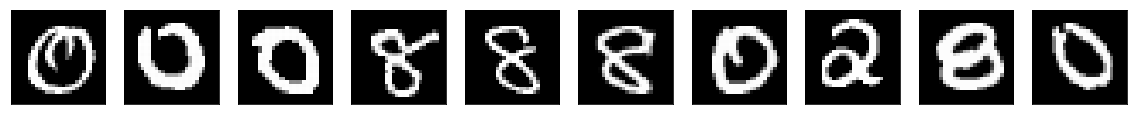

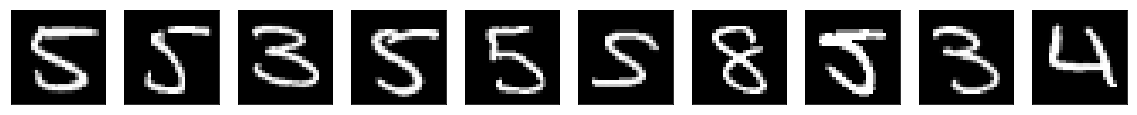

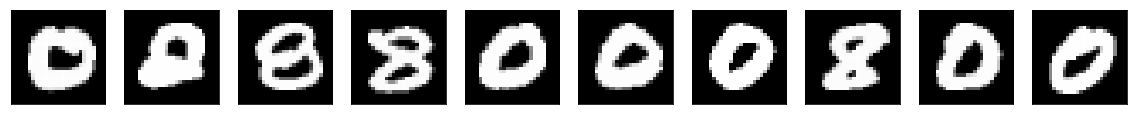

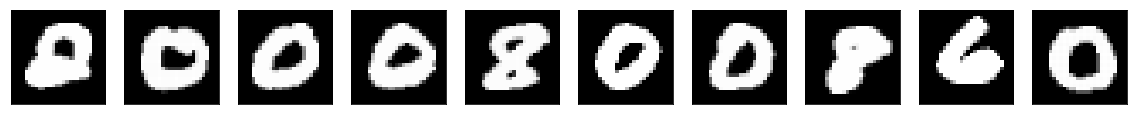

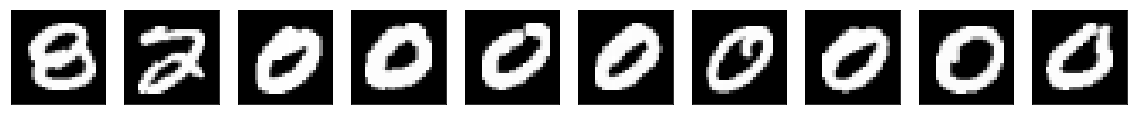

<Figure size 1440x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
from keras.preprocessing import image

print("numneurons ",len(neuronsByImageIndex))
n=10
plt.figure(figsize=(20, 4))
numDisplay = min(len(neuronsByImageIndex),100)
for neuron in range(numDisplay):
    thisNeuron = neuronsByImageIndex[neuron]
    i = 0
#    print("neuron ",neuron)
    for w in sorted(thisNeuron, key=thisNeuron.get, reverse=True)[:n]:
        #print(w, thisNeuron[w])
        # display original
        if thisNeuron[w] > 0.0:
            ax = plt.subplot(2, n, i + 1)
#
# Uncomment these lines if w is a pointer in the image array (like for MNIST)
            img = x_test[w]
            plt.imshow(img.reshape(28,28))
# 
# Uncomment these lines if "w" is the path to the file (like for natural images)
#            img = image.load_img(w.replace('PAS1043','PAS1495'), target_size=(224, 224))
#            plt.imshow(img)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            i += 1
    if i>0:
        plt.show()
        plt.figure(figsize=(20, 4))


## Simple Task
Rerun the above code, but use *layer=3* instead - this will let us look at the filters in the outermost layer.   Do the images you get this way look different?

## Task: Apply to Real Images!
We cac do exactly the same thing using a network that has been trained to classifiy real images.   It turns out that Keras comes with a number of such pre-trained classifiers, see 
the Keras Applications section [here](https://keras.io/applications/) for more details.

We will use the model VGG16.   This is a neural network that performed very well in the Image Net Large Scale Visual Recognition Challenge (ILSVRC) in 2014. It scored first place on the image localization task and second place on the image classification task.

Localization is finding where in the image a certain object is, described by a bounding box. Classification is describing what the object in the image is. This predicts a category label, such as “cat” or “bookcase”.

ImageNet is a huge database of images for academic researchers.  The images used in the competition are divided into 1000 different categories. 

Let's load the model and inspect its structure.

In [8]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
model = VGG16(weights='imagenet')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Loading the pickle files and inspecting the important images

I have already run the above code using this model on the validation images.   The code to run it is included in this directory in the following files:
* pbs_run_calcviz_vgg16_gpu_layer5.sh
* calcviz_vgg16.py

You can rerun these if you like, but each script takes about an hour to run on a gpu!

The resulting pickle files are stored in the scratch area:
* /fs/scratch/PAS1495/physics6820/neuronsByImageIndex_block1_pool.pkl
* /fs/scratch/PAS1495/physics6820/neuronsByImageIndex_block3_pool.pkl
* /fs/scratch/PAS1495/physics6820/neuronsByImageIndex_block5_pool.pkl

In the following code blocks, try looking at each of the files above.  You should see different behavior for each layer: start with the innermost layer, and proceed to the outermost.


In [9]:
#
# Now load the dictionary back!   Usually the saving and re-loading are done in 2 different files!
fname = open(XXXXX, 'rb')
neuronsByImageIndex = pickle.load(fname) 
print("neuronsByImageIndex length",len(neuronsByImageIndex))


NameError: name 'XXXXX' is not defined

In [ ]:
#
# Copy display code from above - be sure to comment/uncomment the appropriate lines!